In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor


## Import Data and Create Training and Testing Sets

In [74]:
full_data = pd.read_csv("data/merged_data_scaled_totals.csv")
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 53 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   State                                   170 non-null    object 
 1   Year                                    170 non-null    int64  
 2   Maternal_Mortality_Rate                 170 non-null    float64
 3   $10,000 to $14,999                      170 non-null    float64
 4   $100,000 to $149,999                    170 non-null    float64
 5   $15,000 to $24,999                      170 non-null    float64
 6   $150,000 to $199,999                    170 non-null    float64
 7   $200,000 or more                        170 non-null    float64
 8   $25,000 to $34,999                      170 non-null    float64
 9   $35,000 to $49,999                      170 non-null    float64
 10  $50,000 to $74,999                      170 non-null    float6

In [75]:
full_data.columns

Index(['State', 'Year', 'Maternal_Mortality_Rate', '$10,000 to $14,999',
       '$100,000 to $149,999', '$15,000 to $24,999', '$150,000 to $199,999',
       '$200,000 or more', '$25,000 to $34,999', '$35,000 to $49,999',
       '$50,000 to $74,999', '$75,000 to $99,999', 'Less than $10,000',
       'Percent_Overweight', 'Percent_Obese', 'Percent_Overweight_or_Obese',
       'Percent_No_Activity', 'Births', 'ChronicHypertensionBirths',
       'DiabetesBirths', 'EnclampsiaBirths',
       'Pregnancy-AssociatedHypertensionBirths', 'TobaccoUseBirths',
       'HospitalBirths', 'ResidenceBirths', 'MD_Delivery', 'DO_Delivery',
       'CNM_Delivery', 'Other_Delivery_Attendant', 'Vaginal_Delivery',
       'Cesarean_Delivery', 'Married', 'Unmarried', 'NoPrenatalCare',
       '1stMonthInitialCare', '2ndMonthInitialCare', '3rdMonthInitialCare',
       '4thMonthInitialCare', '5thMonthInitialCare', '6thMonthInitialCare',
       '7thMonthInitialCare', '8thMonthInitialCare', '9thMonthInitialCare',
    

In [76]:
# perform training and testing split
y = full_data["Maternal_Mortality_Rate"]

features = full_data.columns[3:]
features = features.drop(features[14]) # exclude overall number of births as a feature
X = full_data.loc[:,features]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Pipeline for Trying Different Scalers and Regression Models

In [77]:
# define scalers
scalers = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'none': FunctionTransformer(lambda x: x)  # identity/no scaling
}

# define models and their parameters

models = {
    'baseline': (DummyRegressor(strategy='mean'), {}),
    'linear': (LinearRegression(), {}),
    'ridge': (Ridge(), {'model__alpha': [0.1, 1, 10]}),
    'lasso': (Lasso(), {'model__alpha': [0.1, 1, 10]}),
    'elastic': (ElasticNet(), {
        'model__alpha': [0.1, 1],
        'model__l1_ratio': [0.3, 0.5, 0.7]
    }),
    'svr': (SVR(), {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    }),
    'knn': (KNeighborsRegressor(), {
        'model__n_neighbors': [3, 5, 7]
    }),
    'dtree': (DecisionTreeRegressor(), {
        'model__max_depth': [3, 5, 10, None]
    }),
    'rf': (RandomForestRegressor(), {
        'model__n_estimators': [50, 100],
        'model__max_depth': [3, 5, None]
    }),
    'gboost': (GradientBoostingRegressor(), {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5]
    }),
}

# build full grid
param_grid = []
for scaler_name, scaler in scalers.items():
    for model_name, (model, params) in models.items():
        # some models like trees don't need scaling — skip scaling for those
        if scaler_name != 'none' or model_name in ['ridge', 'lasso', 'elastic', 'svr', 'knn', 'linear']:
            config = {
                'scaler': [scaler],
                'model': [model],
                **params
            }
            param_grid.append(config)

# set up the pipeline (dummy model, gets overridden by GridSearchCV)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit
search.fit(X_train, y_train)

print("Best model:", search.best_estimator_)
print("Best score (MSE):", -search.best_score_)


Fitting 5 folds for each of 104 candidates, totalling 520 fits
Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GradientBoostingRegressor())])
Best score (MSE): 68.43328222264604


# Evalue the Best Model's Performance on the Test Data

In [78]:
from sklearn.metrics import mean_squared_error, r2_score

# get best pipeline
best_model = search.best_estimator_

# predict on test set
y_pred = best_model.predict(X_test)
baseline_pred = y_test.mean() * np.ones(len(y_test))

# evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

baseline_mse = mean_squared_error(y_test, baseline_pred)

print("Final Model Performance on Test Set:")
print(f"Best Model: {best_model}")
print(f"Test MSE: {mse:.4f}")
print("")
print("Baseline Model Performance on Test Set:")
print(f"Test MSE: {baseline_mse:.4f}")

Final Model Performance on Test Set:
Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GradientBoostingRegressor())])
Test MSE: 94.9238

Baseline Model Performance on Test Set:
Test MSE: 182.0066


# Determine the Feature Importance of the Best Model

In [79]:
# get best model
best_model = search.best_estimator_

# Get feature names from X_train
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns
else:
    feature_names = np.array([f'feature_{i}' for i in range(X_train.shape[1])])

# Determine feature importance based on model type
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    # For models that provide feature importances (e.g., RandomForest, GradientBoosting, DecisionTree)
    feature_importance = best_model.named_steps['model'].feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

elif hasattr(best_model.named_steps['model'], 'coef_'):
    # For linear models (e.g., LinearRegression, Ridge, Lasso, ElasticNet)
    feature_importance = best_model.named_steps['model'].coef_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(feature_importance)  # Taking absolute values of coefficients
    }).sort_values(by='Importance', ascending=False)

else:
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.zeros(len(feature_names))  # No feature importance available for this model
    })

# Print the feature importance
print("Feature Importances:")
print(importance_df)


Feature Importances:
                                   Feature  Importance
39                      UnknownInitialCare    0.275119
29                          NoPrenatalCare    0.057443
42                              28-31Weeks    0.056468
13                     Percent_No_Activity    0.054622
24                Other_Delivery_Attendant    0.053410
7                       $50,000 to $74,999    0.053179
19                          HospitalBirths    0.046448
44                                 36Weeks    0.034198
23                            CNM_Delivery    0.031011
26                       Cesarean_Delivery    0.023501
43                              32-35Weeks    0.022463
47                                 41Weeks    0.022279
32                     3rdMonthInitialCare    0.019958
6                       $35,000 to $49,999    0.018651
45                              37-39Weeks    0.018565
46                                 40Weeks    0.015609
5                       $25,000 to $34,999  

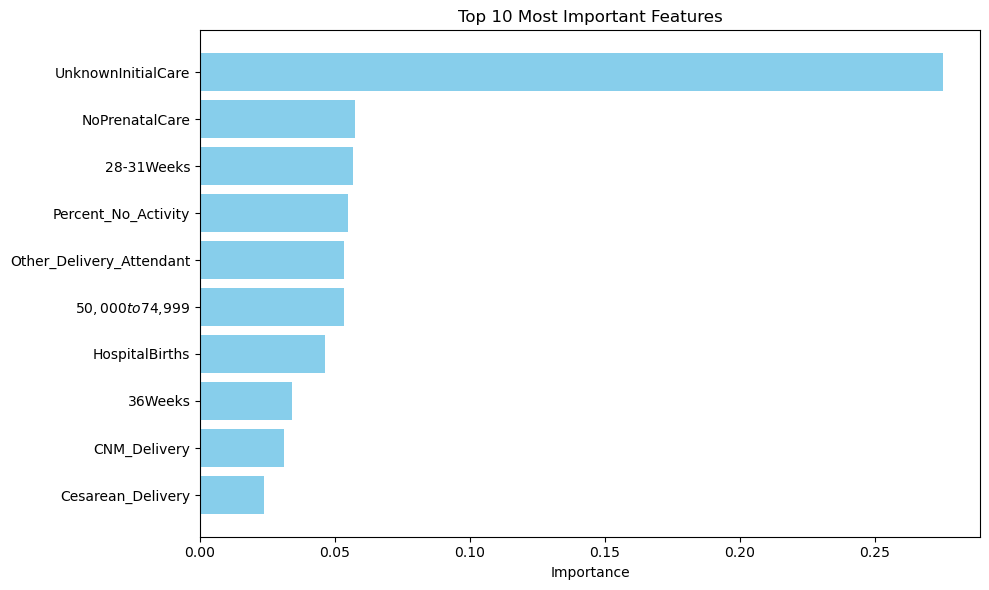

In [80]:
# Get top 10 features
top_n = 10
top_features = importance_df.head(top_n)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Importance")
plt.title(f"Top {top_n} Most Important Features")
plt.tight_layout()
plt.show()

# Store the Results of GridSearchCV

In [81]:
# Convert to DataFrame
results_df = pd.DataFrame(search.cv_results_)

# Convert scores from negative MSE to positive for readability
results_df['mean_test_MSE'] = -results_df['mean_test_score']

# Sorted results by performance
sorted_results = results_df.sort_values(by='mean_test_MSE')

# Store results

sorted_results.to_csv("data/model_performance.csv")

sorted_results.iloc[0:]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_scaler,param_model__alpha,param_model__l1_ratio,param_model__C,param_model__kernel,...,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_test_MSE
38,0.131611,0.010972,0.002198,0.000872,GradientBoostingRegressor(),StandardScaler(),NaN,NaN,NaN,NaN,...,"{'model': GradientBoostingRegressor(), 'model_...",-64.372328,-42.650764,-88.037113,-55.571335,-91.534871,-68.433282,18.786446,1,68.433282
79,0.128428,0.013321,0.001381,0.000318,GradientBoostingRegressor(),MinMaxScaler(),NaN,NaN,NaN,NaN,...,"{'model': GradientBoostingRegressor(), 'model_...",-62.124066,-49.916566,-86.764105,-54.999586,-99.710449,-70.702955,19.244024,2,70.702955
37,0.063494,0.003977,0.001855,0.001105,GradientBoostingRegressor(),StandardScaler(),NaN,NaN,NaN,NaN,...,"{'model': GradientBoostingRegressor(), 'model_...",-65.360477,-44.940489,-93.998349,-53.207670,-97.894314,-71.080260,21.352589,3,71.080260
78,0.060519,0.006749,0.001568,0.000298,GradientBoostingRegressor(),MinMaxScaler(),NaN,NaN,NaN,NaN,...,"{'model': GradientBoostingRegressor(), 'model_...",-66.091254,-45.962502,-98.474110,-55.060644,-107.218074,-74.561317,24.117197,4,74.561317
61,0.002170,0.000721,0.002444,0.001617,KNeighborsRegressor(),MinMaxScaler(),NaN,NaN,NaN,NaN,...,"{'model': KNeighborsRegressor(), 'model__n_nei...",-103.211600,-36.946708,-90.333992,-39.119599,-108.780700,-75.678520,31.321927,5,75.678520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.001713,0.000181,0.001678,0.000481,KNeighborsRegressor(),FunctionTransformer(func=<function <lambda> at...,NaN,NaN,NaN,NaN,...,"{'model': KNeighborsRegressor(), 'model__n_nei...",-160.470149,-82.567690,-165.243796,-114.203883,-192.175531,-142.932210,39.241516,100,142.932210
24,0.004756,0.001583,0.001327,0.000494,DecisionTreeRegressor(),StandardScaler(),NaN,NaN,NaN,NaN,...,"{'model': DecisionTreeRegressor(), 'model__max...",-101.779915,-102.290445,-216.896198,-116.981897,-180.912243,-143.772140,46.751064,101,143.772140
96,0.002756,0.000079,0.001808,0.000500,SVR(),FunctionTransformer(func=<function <lambda> at...,NaN,NaN,0.1,rbf,...,"{'model': SVR(), 'model__C': 0.1, 'model__kern...",-213.115958,-72.675793,-149.236808,-133.681295,-158.725387,-145.487048,45.174857,102,145.487048
64,0.004778,0.003766,0.001460,0.000772,DecisionTreeRegressor(),MinMaxScaler(),NaN,NaN,NaN,NaN,...,"{'model': DecisionTreeRegressor(), 'model__max...",-122.791286,-114.003604,-170.462381,-181.028151,-151.488620,-147.954808,26.072253,103,147.954808
